# Testing and evaluating model

In this notebook:

1.   Test data preparation
2.   Create function to dispay image batch with original and predicted labels
3.   Load ready model from file
4.   Test model's performance on sample data batch
5.   Explanations with LIME
6.   Compute predictions for test set and create confusion matrix
7.   Compute precision, recall and accuracy scores for test set



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import pathlib

In [0]:
#Path to the dataset
test_dir = '/content/gdrive/My Drive/dataset/3_test'
test_dir = pathlib.Path(test_dir)
test_count = len(list(test_dir.glob('*/*.png')))
CLASS_NAMES = np.array(['bad', 'good'])

In [0]:
#Function for displaying batch with original and predicted classes
def show_batch(image_batch, label_batch, pred=[]):
  plt.figure(figsize=(20,20))
  for n in range(32):
      ax = plt.subplot(4,8,n+1)
      plt.imshow(image_batch[n])
      if len(pred)==0:
        plt.title(str(CLASS_NAMES[int(label_batch[n])]))
      else:
        plt.title("orig: "+str(CLASS_NAMES[int(label_batch[n])])+"\npred: "+str(CLASS_NAMES[int(pred[n])]))
      plt.axis('off')

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 229
IMG_WIDTH = 229
STEPS_PER_EPOCH_T = np.ceil(test_count/BATCH_SIZE)

In [0]:
#Test batches generator
#Use first option and shuffle=True when testing, displaying and explaining sample batch(1st part)
#Use second option and shuffle=False when evaluating and computing predictions(2nd part)

test_datagen = keras.preprocessing.image.ImageDataGenerator()
# test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

test_generator = test_datagen.flow_from_directory(directory=str(test_dir),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  # shuffle=False,
                                                  classes = list(CLASS_NAMES),
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 800 images belonging to 2 classes.


In [0]:
#Load ready model from file
if not 'model' in locals():
  model = tf.keras.models.load_model('/content/gdrive/My Drive/image_x_model.h5')

## 1st part

In [0]:
#Take sample batch from test dataset
image_batch, label_batch = next(test_generator)

#Prepare batch for prediction - apply Xception's preprocess_input function to images
batch_to_predict = np.copy(image_batch)
to_pred = np.vectorize(keras.applications.xception.preprocess_input)
batch_to_predict = to_pred(batch_to_predict)

#Prepare batch for display - apply rescaling to images
batch_to_show = np.copy(image_batch)
to_show = np.vectorize(lambda t: t * 1./255)
batch_to_show = to_show(batch_to_show)

#Use model to make predictions
y_pred = model.predict(batch_to_predict)

#Predict method returns list of probabilities of being a good and bad picture for each image in a batch
#Here change it to list of labels good(1) and bad(0)
pred = []
for x,y in y_pred:
  if x >= y:
    pred.append(0)
  else:
    pred.append(1)

In [0]:
#Display confusion matrix for samlpe batch
from sklearn.metrics import confusion_matrix

confusion_matrix(label_batch[:,1].astype('int'), pred)

array([[29,  0],
       [ 1,  2]])

In [0]:
#Compare predicted and original lables
print(pred)
print(list(label_batch[:,1].astype('int')))

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


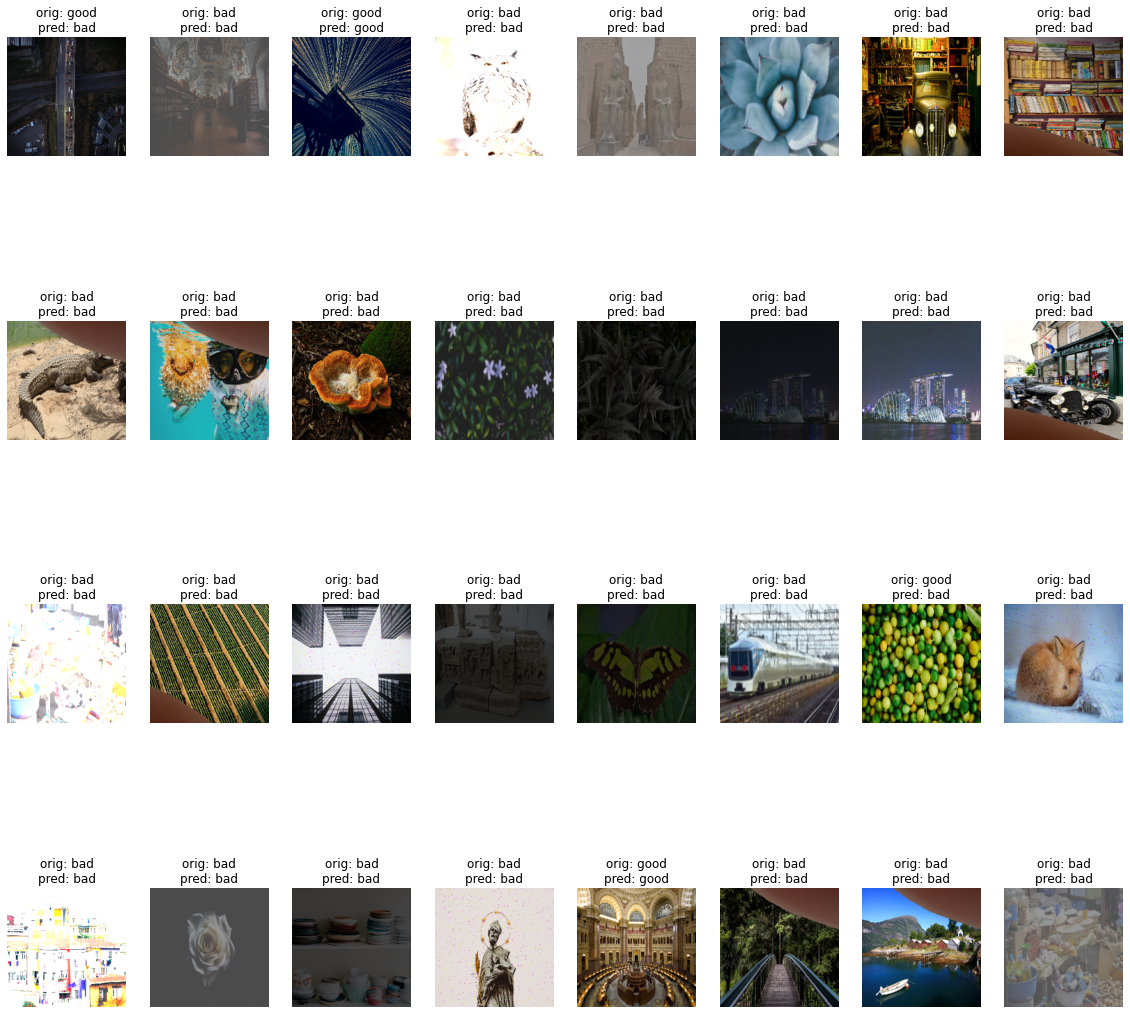

In [0]:
#Display batch of images with their original and predicted labels
show_batch(batch_to_show, label_batch[:,1], pred)

### Simple lime

In [0]:
#Choose image to be explained from previously generated sample batch
IMG_NUMBER = 29

In [0]:
#Use lime to explain model's decision of being bad or good for a given image
img = batch_to_predict[IMG_NUMBER]
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model.predict)

In [0]:
#Display original image with the areas deciding about belongingness to bad-0 or good-1 class
CLASS = 1
temp, mask = explanation.get_image_and_mask(explanation.top_labels[CLASS], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
#Display image with mask alongside with the original image
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
f.add_subplot(1,2, 2)
plt.imshow(batch_to_show[IMG_NUMBER])

# LIME

In [0]:
!pip install shap
!pip install lime
!pip install eli5

In [0]:
import lime
from lime import lime_image
from keras.preprocessing import image
from skimage.segmentation import mark_boundaries

Using TensorFlow backend.


In [0]:
#Path to the dataset with photos for lime
lime_dir = '/content/gdrive/My Drive/dataset/lime2'
lime_dir = pathlib.Path(lime_dir)

In [0]:
#Batch generator
#Each batch contains one good and seven bad pictures based on the same original photo
lime_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)
lime_generator = lime_datagen.flow_from_directory(directory=str(lime_dir),
                                                  batch_size=8,
                                                  shuffle=False,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 8 images belonging to 2 classes.


In [0]:
#Predictions for image batch
lime_image_batch, lime_label_batch = next(lime_generator)
lime_pred = model.predict(lime_image_batch)
pred_tab = []
for x,y in lime_pred:
  if x >= y:
    pred_tab.append(0)
  else:
    pred_tab.append(1)

In [0]:
#Create lime explainer and generate explanations for both classes for each image
explainer = lime_image.LimeImageExplainer()

#This part is only for creation of proper size matrices, those instances are deleted at the end
explanation = explainer.explain_instance(lime_image_batch[0], model.predict)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)

temps = np.expand_dims(temp, axis=0)
masks = np.expand_dims(mask, axis=0)

#Explanation part
#For each image in a batch explanation is created alongside with masks showing areas responsible for classifying each image to good or bad class
for f in lime_image_batch:
  explanation = explainer.explain_instance(f, model.predict)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
  temps = np.vstack((temps, np.expand_dims(temp, axis=0)))
  masks = np.vstack((masks, np.expand_dims(mask, axis=0)))

#Delete redundant first row
temps = np.delete(temps, 0,0)
masks = np.delete(masks, 0,0)

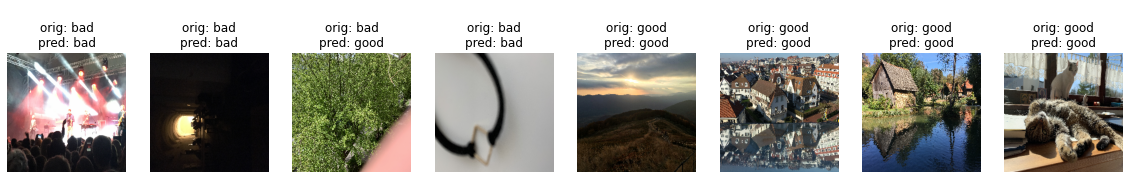

In [0]:
#Display batch of images with their original and predicted classes
defects = ['too bright', 'too dark', 'blured', 'noisy', 'finger lower-left', 'finger upper-right', 'low contrast', 'original']
plt.figure(figsize=(20,20))
for n in range(8):
    ax = plt.subplot(3,8,n+1)
    plt.imshow(lime_image_batch[n]/ 2 + 0.5)
    if len(pred)==0:
      plt.title(str(CLASS_NAMES[int(lime_label_batch[:,1][n])]))
    else:
      plt.title("\norig: "+str(CLASS_NAMES[int(lime_label_batch[:,1][n])])+"\npred: "+str(CLASS_NAMES[int(pred_tab[n])]))
    plt.axis('off')

Why is it good or bad: 


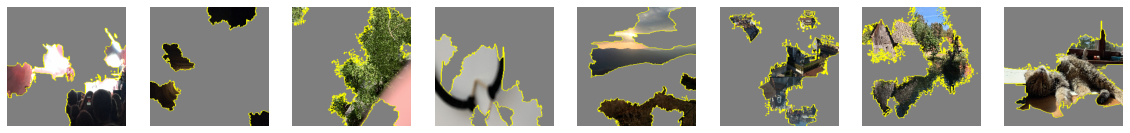

In [0]:
#Display batch of images with mask saying which areas would indicate that image is bad
print("Why is it good or bad: ")
plt.figure(figsize=(20,20))
for n in range(8):
    ax = plt.subplot(1,8,n+1)
    plt.imshow(mark_boundaries(temps[n] / 2 + 0.5, masks[n]))
    plt.axis('off')

# 2nd part

In [0]:
#Evaluate model on the test set
#Make predictions
predictions = model.predict(test_generator, steps=STEPS_PER_EPOCH_T)

In [0]:
#Again changing probabilities to classes
from sklearn.metrics import confusion_matrix
full_pred = []
for x,y in predictions:
  if x >= y:
    full_pred.append(0)
  else:
    full_pred.append(1)
confusion_matrix(test_generator.classes, full_pred)

array([[28, 10],
       [ 6, 52]])

In [0]:
#Compute recall, precision and accuracy scores for test set
from sklearn.metrics import recall_score, precision_score, accuracy_score
print("Precision:", precision_score(test_generator.classes, full_pred), "\nRecall:", recall_score(test_generator.classes, full_pred), 
      "\nAccuracy:", accuracy_score(test_generator.classes, full_pred))

Precision: 0.8387096774193549 
Recall: 0.896551724137931 
Accuracy: 0.8333333333333334


In [0]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [0]:
np.array(full_pred)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1])